/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-07-23_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-07-23_Sensors_100Hz.pkl
/home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-07-24_Sensors_100Hz.pkl
Loading  /home/thompsong/work/PROJECTS/KSC_EROSION/corrected/combined/2022-07-24_Sensors_100Hz.pkl
resampling to 60-s sampling interval, taking median of each timewindow
                      1226421   1226419    1226420   2149882   2151691  \
datetime                                                                 
2022-07-23 00:00:00  3.962076  3.331521  14.668175  8.720188  8.674980   
2022-07-23 00:01:00  3.961837  3.331334  14.668059  8.720059  8.674850   
2022-07-23 00:02:00  3.961296  3.330787  14.668133  8.720067  8.674903   
2022-07-23 00:03:00  3.959598  3.329067  14.668156  8.720027  8.674903   
2022-07-23 00:04:00  3.959067  3.328551  14.668085  8.719897  8.674687   
...                       ...    

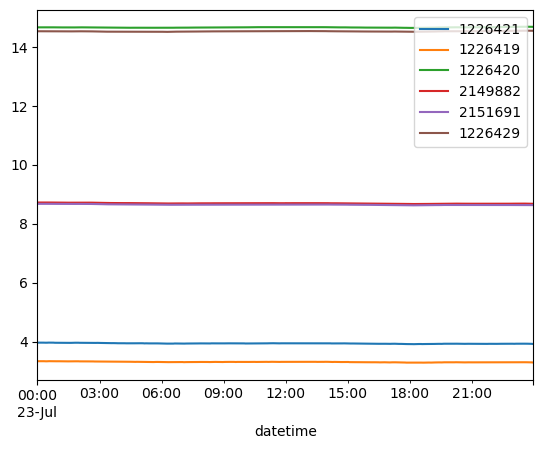

In [25]:
import header
paths = header.setup_environment()
import os
#import sys
#import glob
#import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd
#from obspy.core import read, Stream, UTCDateTime
#from obspy.core import UTCDateTime
#import FDSNtools
#import wrappers
#import SDS
#import libWellData as LLE
import matplotlib
matplotlib.use( 'tkagg' )
%matplotlib inline
#plot_each_file = False

import datetime
import glob
from obspy import UTCDateTime
COMBINED_DIR = os.path.join(paths['CORRECTED'], 'combined')
import time

def plot_pickles(start_dt, end_dt, instruments='Sensors', fs=100, resample=True, new_interval=None, max_samples=1000):
    start_date = start_dt.date()
    end_date = end_dt.date()    
    
    delta = datetime.timedelta(days=1)
    this_date = start_date
    combineddf = pd.DataFrame()
    while this_date <= end_date:
        #print(this_date.strftime("%Y-%m-%d"))
        combined_pklfile = f"{this_date}_{instruments}_{fs}Hz.pkl"
        combined_pklpath = os.path.join(COMBINED_DIR, combined_pklfile)
        print(combined_pklpath)
        if os.path.isfile(combined_pklpath):
            print('Loading ',combined_pklpath)
            if len(combineddf)>0:
                df = pd.read_pickle(combined_pklpath)
                combineddf = pd.concat([combineddf, df])
            else:
                combineddf = pd.read_pickle(combined_pklpath)
        else:
            print('file not found: ', combined_pklpath)
        this_date += delta

    if not 'datetime'  in combineddf.columns:
        combineddf['datetime'] = [UTCDateTime(ts).datetime for ts in combineddf['TIMESTAMP']]

    # apply time subset
    mask = (combineddf['datetime'] >= start_dt) & (combineddf['datetime'] < end_dt)
    combineddf = combineddf.loc[mask]

    combineddf.set_index('datetime', inplace=True)
    combineddf.drop(columns=['TIMESTAMP', 'date', 'RECORD'], inplace=True)

    if resample or new_interval:
        if not new_interval:
            seconds = [1, 5, 10, 60, 300, 600, 900, 1800, 3600]
            seconds_index = 0
            estimated_delta = len(combineddf)/(max_samples * fs)
            
            while seconds[seconds_index] <= estimated_delta:
                seconds_index += 1
        
            new_interval = seconds[seconds_index] 
    
        print(f'resampling to {new_interval}-s sampling interval, taking median of each timewindow')
        combineddf = combineddf.resample(f"{new_interval}s").median()

    #combineddf.reset_index(inplace=True)
    combineddf.plot(y=combineddf.columns)

    return combineddf

start_dt = datetime.datetime(2022,7,23,0,0,0)
end_dt = datetime.datetime(2022,7,24,0,0,0)
combineddf = plot_pickles(start_dt, end_dt, instruments='Sensors', fs=100, new_interval=60)
print(combineddf)

In [ ]:
'''

# Parse lookuptable
lookuptableDF = LLE.removed_unnamed_columns(pd.read_csv(paths['lookuptable']))
lookuptableDF.to_csv('lookuptable_backup.csv')
lookuptableDF = lookuptableDF.sort_values(by=['starttime'])
lookuptableDF['miniseed'] = False
print(paths)

COMBINED_DIR = os.path.join(paths['CORRECTED'], 'combined')
if not os.path.isdir(COMBINED_DIR):
    os.makedirs(COMBINED_DIR)

transducersDF = LLE.removed_unnamed_columns(pd.read_csv(paths['transducersCSVfile']))
MSEED_DIR = os.path.join(paths['outdir'], 'miniseed')
#os.system(f"rm -rf {MSEED_DIR}/*")
for index, row in lookuptableDF.iterrows():
    filename = row['outputfile']  
    filepath = os.path.join(paths['CORRECTED'],filename)
    df = LLE.removed_unnamed_columns(pd.read_csv(filepath))
    df['datetime'] = [UTCDateTime(ts).datetime for ts in df['TIMESTAMP']]
    df['date'] = df['datetime'].dt.date
    unique_dates = df['date'].unique()
    num_days = len(unique_dates)
    print(filepath,' has length: ',len(df), ' and contains ',num_days, ' unique dates')

    if plot_each_file:
        N = len(df.columns) - 3
        if N>0:
            fig, axs = plt.subplots(N, 1)
            fig.suptitle(filename)
            for i, col in enumerate(df.columns[2:-1]):
                print(col)
                df.plot(x='datetime', y=col, ax = axs[i])
            fig.savefig(filename.replace('csv','.png'))

    YMD, folder, basename, ext = filename.split('.') # YMD is just upload date
    fs, instruments, blah = basename.split('_')
    fs, crap = fs.split('hz')
    YYYY = YMD[0:4]
    MM = YMD[4:6]
    DD = YMD[6:8]
    if 'Sec' in blah:
        secs, seqno = blah.split('Sec')
        fs = int(1/float(secs))
    elif 'Hz' in blah:
        fs, seqno = blah.split('Hz')
    elif 'Sensors' in blah:
        crap, seqno = blah.split('Sensors')


    for this_date in unique_dates:
        print(this_date)
        df2  = df[(df['date'] == this_date)]
        print(df2)
        
        combined_pklfile = f"{this_date}_{instruments}_{fs}Hz.pkl"
        print(f"{filename} -> {combined_pklfile}", '\n\n')
        combined_pklpath = os.path.join(COMBINED_DIR, combined_pklfile)
        if os.path.isfile(combined_pklpath):
            try:
                masterdf = pd.read_pickle(combined_pklpath)
                combineddf = pd.concat([masterdf, df2])
                print(combineddf)
                combineddf.to_pickle(combined_pklpath)
            except Exception as e:
                print(e)
        else:
            df2.to_pickle(combined_pklpath)
        
'''